In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import keras_tuner

from keras.utils import load_img, img_to_array, image_dataset_from_directory, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Conv2D, Flatten, Dense, Input, Dropout, MaxPooling2D, BatchNormalization, RandomContrast, RandomRotation, RandomFlip
from keras.models import Sequential
from keras.saving import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
file_path_train = './Images/images/train/'
file_path_test = './Images/images/validation/'
expressions_list = ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

In [3]:
# Choose and expression to explore

expression = 'disgusted'


In [4]:
# let's look att the first image in that directory

img0 = os.listdir(f"{file_path_train}{expression}")[0]
img0 = f'{file_path_train}{expression}/{img0}'
img0

'./Images/images/train/disgusted/10018.jpg'

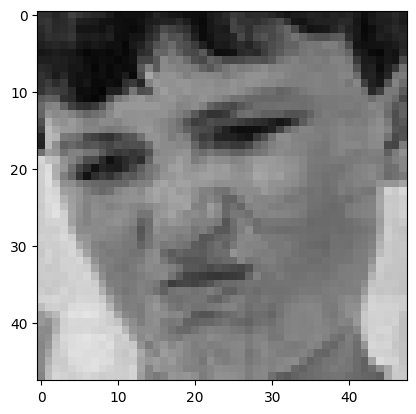

(48, 48, 3)


In [5]:
# Show the picture

img = load_img(img0)
plt.imshow(img)
plt.show()
img_array = img_to_array(img)
print(img_array.shape)

# We now know the first image is 48x48 pixels. Are all the same?

In [6]:
imglist = [f"{file_path_train}{expression}/{i}" for i in os.listdir(f"{file_path_train}{expression}")[:100]]

In [7]:
imglist_as_img = [load_img(i) for i in imglist]
imglist_as_arrays = [img_to_array(i) for i in imglist_as_img]
for i in imglist_as_arrays[:10]:
    print(i.shape)

(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


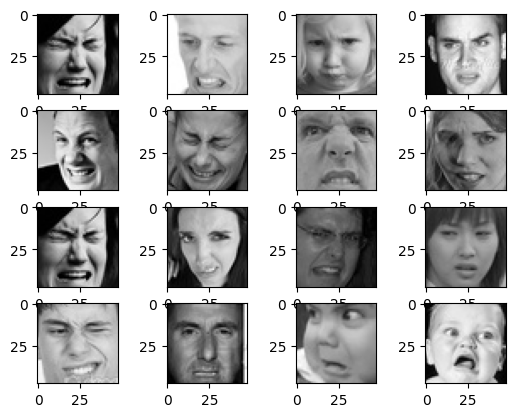

In [8]:
for i in range(1, 17):
    plt.subplot(4, 4, i)
    img = imglist_as_img[i]
    plt.imshow(img)

plt.show()

In [9]:
# How many files in each directory?
for expression in expressions_list:
    print(f'{expression}: ', len([f"{file_path_train}{expression}" for i in os.listdir(f"{file_path_train}{expression}")]))

afraid:  4103
angry:  3993
disgusted:  436
happy:  7164
neutral:  4982
sad:  4938
surprised:  3205


In [10]:
for expression in expressions_list:
    print(f'{expression}: ', len([f"{file_path_test}{expression}" for i in os.listdir(f"{file_path_test}{expression}")]))

afraid:  1018
angry:  960
disgusted:  111
happy:  1825
neutral:  1216
sad:  1139
surprised:  797


Create datasets from these directories

In [11]:

train_dataset, validation_dataset = image_dataset_from_directory(file_path_train, labels='inferred', batch_size=None, label_mode='categorical', color_mode='grayscale', 
                                             validation_split=0.2, image_size=(48, 48), subset='both', seed=42)
test_dataset = image_dataset_from_directory(file_path_test, labels='inferred', batch_size=None, label_mode='categorical', color_mode='grayscale', image_size=(48, 48), seed=42)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Using 5764 files for validation.
Found 7066 files belonging to 7 classes.


In [12]:
len_train = len(train_dataset)
len_test = len(test_dataset)

X_train = []
y_train = []

for i, (images, labels) in enumerate(train_dataset):
    X_train.append(images.numpy())
    y_train.append(labels.numpy())
    if i == (len_train-1):
        break

X_train = np.asarray(X_train) / 255
y_train = np.asarray(y_train)


# Validation

num_images_val = len(validation_dataset)

X_val = []
y_val = []

for i, (images, labels) in enumerate(validation_dataset):
    X_val.append(images.numpy())
    y_val.append(labels.numpy())
    if i == (num_images_val-1):
        break


X_val = np.asarray(X_val) / 255
y_val = np.asarray(y_val)


num_batches_test = len_test

X_test = []
y_test = []

for i, (images, labels) in enumerate(test_dataset):
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
    if i == (len_test-1):
        break

X_test = np.asarray(X_test) / 255
y_test = np.asarray(y_test)

In [13]:
reduced_training_len = 5000
reduced_val_len = 1000
reduced_test_len = 1000

In [14]:
X_train_reduced = X_train[:reduced_training_len]
y_train_reduced = y_train[:reduced_training_len]
X_val_reduced = X_val[:reduced_val_len]
y_val_reduced = y_val[:reduced_val_len]
X_test_reduced = X_test[:reduced_test_len]
y_test_reduced = y_test[:reduced_test_len]

Create a basic model to show it works

In [15]:
model_0 = Sequential()
model_0.add(Conv2D(64, kernel_size=2, activation='relu', padding='same', input_shape=(48, 48, 1)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Dropout(0.2))
model_0.add(Flatten())
model_0.add(Dense(7, activation='softmax'))

early_stop = EarlyStopping(patience=3)

checkpoint_model_0 = ModelCheckpoint('./model_0.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model_0.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 7)                 258055    
                                                                 
Total params: 258375 (1009.28 KB)
Trainable params: 258375 (1009.28 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [17]:
history_0 = model_0.fit(X_train_reduced, y_train_reduced, validation_data=(X_val_reduced, y_val_reduced), callbacks=[early_stop, checkpoint_model_0], epochs=25)

Epoch 1/25
157/157 [==============================] - ETA: 0s - loss: 1.7843 - accuracy: 0.2882
Epoch 1: val_accuracy improved from -inf to 0.31900, saving model to .\model_0.h5
157/157 [==============================] - 8s 46ms/step - loss: 1.7843 - accuracy: 0.2882 - val_loss: 1.6941 - val_accuracy: 0.3190
Epoch 2/25
  3/157 [..............................] - ETA: 6s - loss: 1.6286 - accuracy: 0.3125

c:\Users\olofs\anaconda3\envs\deep_learning\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - ETA: 0s - loss: 1.6038 - accuracy: 0.3886
Epoch 2: val_accuracy improved from 0.31900 to 0.33900, saving model to .\model_0.h5
157/157 [==============================] - 7s 46ms/step - loss: 1.6038 - accuracy: 0.3886 - val_loss: 1.6439 - val_accuracy: 0.3390
Epoch 3/25
156/157 [============================>.] - ETA: 0s - loss: 1.5008 - accuracy: 0.4439
Epoch 3: val_accuracy improved from 0.33900 to 0.37500, saving model to .\model_0.h5
157/157 [==============================] - 7s 45ms/step - loss: 1.5007 - accuracy: 0.4442 - val_loss: 1.6139 - val_accuracy: 0.3750
Epoch 4/25
156/157 [============================>.] - ETA: 0s - loss: 1.4018 - accuracy: 0.4818
Epoch 4: val_accuracy improved from 0.37500 to 0.38400, saving model to .\model_0.h5
157/157 [==============================] - 7s 46ms/step - loss: 1.4011 - accuracy: 0.4824 - val_loss: 1.5701 - val_accuracy: 0.3840
Epoch 5/25
156/157 [============================>.] - ETA: 0s - loss: 1.

In [18]:
model_0_eva = model_0.evaluate(X_test_reduced, y_test_reduced)
model_0_eva

32/32 [==============================] - 0s 12ms/step - loss: 1.6178 - accuracy: 0.3770


[1.6178438663482666, 0.37700000405311584]

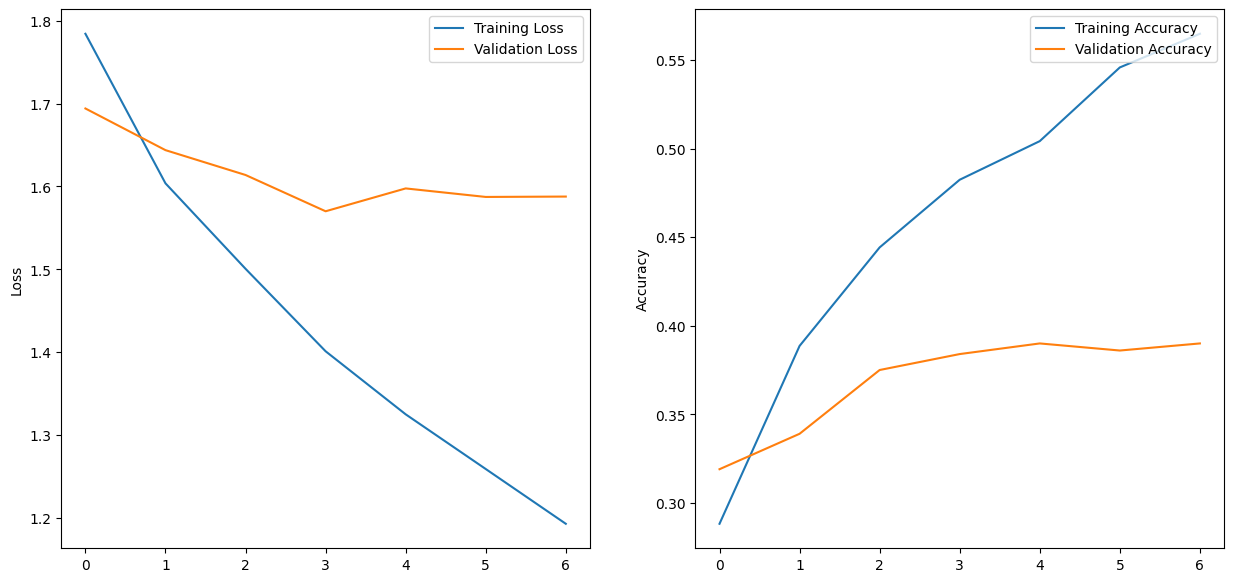

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(history_0.history['loss'], label='Training Loss')
plt.plot(history_0.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(history_0.history['accuracy'], label='Training Accuracy')
plt.plot(history_0.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

40% accuracy is not bad for such a simple model. What if we make it more complex? Kernel size changed to 3

In [20]:
model_1 = Sequential()
model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(512, kernel_size=3, activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.2))
model_1.add(Flatten())
model_1.add(Dense(7, activation='softmax'))

early_stop = EarlyStopping(patience=4)
reduce_lr_loss = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.0001)

checkpoint_model_1 = ModelCheckpoint('./model_1.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model_1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 128)      

In [22]:
history_1 = model_1.fit(X_train_reduced, y_train_reduced, validation_data=(X_val_reduced, y_val_reduced), callbacks=[early_stop, reduce_lr_loss, checkpoint_model_1], epochs=25)

Epoch 1/25
157/157 [==============================] - ETA: 0s - loss: 1.8228 - accuracy: 0.2624
Epoch 1: val_accuracy improved from -inf to 0.23400, saving model to .\model_1.h5
157/157 [==============================] - 39s 244ms/step - loss: 1.8228 - accuracy: 0.2624 - val_loss: 1.8199 - val_accuracy: 0.2340 - lr: 0.0010
Epoch 2/25
157/157 [==============================] - ETA: 0s - loss: 1.7951 - accuracy: 0.2720
Epoch 2: val_accuracy improved from 0.23400 to 0.24100, saving model to .\model_1.h5
157/157 [==============================] - 38s 241ms/step - loss: 1.7951 - accuracy: 0.2720 - val_loss: 1.8169 - val_accuracy: 0.2410 - lr: 0.0010
Epoch 3/25
157/157 [==============================] - ETA: 0s - loss: 1.7710 - accuracy: 0.2788
Epoch 3: val_accuracy improved from 0.24100 to 0.24500, saving model to .\model_1.h5
157/157 [==============================] - 39s 251ms/step - loss: 1.7710 - accuracy: 0.2788 - val_loss: 1.7800 - val_accuracy: 0.2450 - lr: 0.0010
Epoch 4/25
157/157 

In [23]:
model_1_eva = model_1.evaluate(X_test_reduced, y_test_reduced)
model_1_eva

32/32 [==============================] - 1s 32ms/step - loss: 1.4375 - accuracy: 0.5020


[1.437471866607666, 0.5019999742507935]

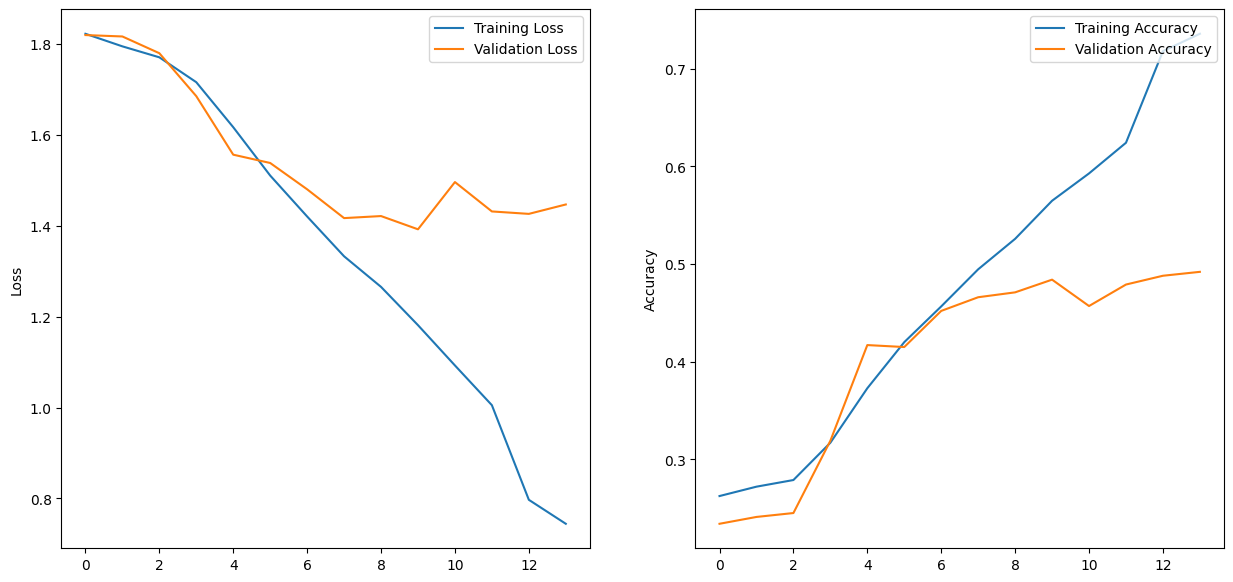

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

We have now trained two different models, let's use keras tuner

In [25]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(48, 48, 1)))
    model.add(Conv2D(hp.Int('filters_0', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Choice('kernel_0', [2, 3]), 
                     activation=hp.Choice('activation_0', ['relu', 'tanh'])
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if hp.Boolean('dropout_0'):
        model.add(Dropout(hp.Float('rate_0', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Conv2D(hp.Int('filters_1', min_value=128, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_1', [2, 3]),
                     activation=hp.Choice('activation_1', ['relu', 'tanh'])
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if hp.Boolean('dropout_1'):
        model.add(Dropout(hp.Float('rate_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Conv2D(hp.Int('filters_2', min_value=256, max_value=512, step=32),
                     kernel_size=hp.Choice('kernel_2', [2, 3]),
                     activation=hp.Choice('activation_2', ['relu', 'tanh'])
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if hp.Boolean('dropout_2'):
        model.add(Dropout(hp.Float('rate_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))

   
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=7, executions_per_trial=2)
tuner.search(X_train_reduced, y_train_reduced, epochs=5, validation_data=(X_val_reduced, y_val_reduced))

Trial 7 Complete [00h 04m 16s]
val_loss: 1.5098979473114014

Best val_loss So Far: 1.4485418200492859
Total elapsed time: 00h 30m 03s


In [29]:
best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'filters_0': 32,
 'kernel_0': 3,
 'activation_0': 'tanh',
 'dropout_0': True,
 'filters_1': 224,
 'kernel_1': 2,
 'activation_1': 'tanh',
 'dropout_1': False,
 'filters_2': 384,
 'kernel_2': 2,
 'activation_2': 'relu',
 'dropout_2': True,
 'rate_0': 0.2,
 'rate_2': 0.2}

In [30]:
models = tuner.get_best_models(num_models=2)
best_tuned_model = models[0]
best_tuned_model.build(input_shape=(48, 48, 1))
best_tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 224)       28896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 384)       3

In [31]:
tuner_checkpoint = ModelCheckpoint('./tuned_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [32]:
best_tuned_model_history = best_tuned_model.fit(X_train_reduced, y_train_reduced, validation_data=(X_val_reduced, y_val_reduced), callbacks=[early_stop, reduce_lr_loss, tuner_checkpoint], epochs=25)

Epoch 1/25
156/157 [============================>.] - ETA: 0s - loss: 1.2508 - accuracy: 0.5258
Epoch 1: val_accuracy improved from -inf to 0.46500, saving model to .\tuned_model.h5
157/157 [==============================] - 18s 110ms/step - loss: 1.2507 - accuracy: 0.5260 - val_loss: 1.4418 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 2/25
156/157 [============================>.] - ETA: 0s - loss: 1.1635 - accuracy: 0.5651
Epoch 2: val_accuracy did not improve from 0.46500
157/157 [==============================] - 17s 108ms/step - loss: 1.1633 - accuracy: 0.5654 - val_loss: 1.4600 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 3/25
156/157 [============================>.] - ETA: 0s - loss: 1.0754 - accuracy: 0.5956
Epoch 3: val_accuracy did not improve from 0.46500
157/157 [==============================] - 17s 108ms/step - loss: 1.0751 - accuracy: 0.5956 - val_loss: 1.5393 - val_accuracy: 0.4540 - lr: 0.0010
Epoch 4/25
156/157 [============================>.] - ETA: 0s - loss: 0.8460 - accu

In [33]:
best_tuned_model_eva = best_tuned_model.evaluate(X_test_reduced, y_test_reduced)
best_tuned_model_eva

32/32 [==============================] - 1s 22ms/step - loss: 1.5669 - accuracy: 0.4770


[1.5668551921844482, 0.47699999809265137]

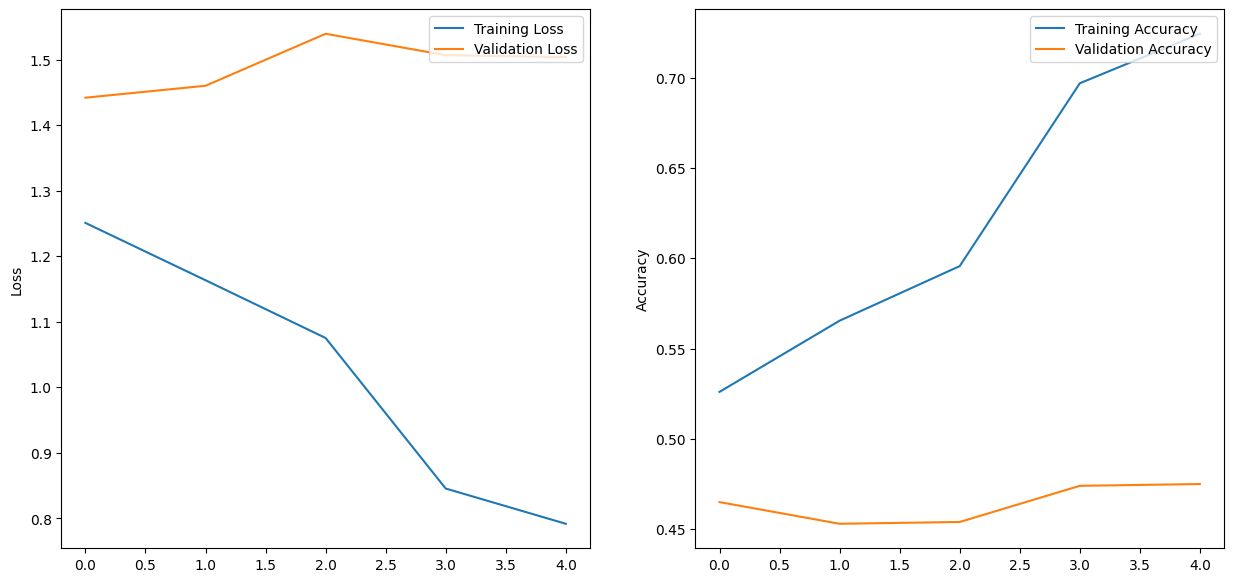

In [34]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(best_tuned_model_history.history['loss'], label='Training Loss')
plt.plot(best_tuned_model_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(best_tuned_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_tuned_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

In [56]:
model_0_eva_loaded = load_model('./model_0.h5')
model_1_eva_loaded = load_model('./model_1.h5')
tuned_model_loaded = load_model('./tuned_model.h5')
eva_loaded_0 = model_0_eva_loaded.evaluate(X_val_reduced, y_val_reduced)
eva_loaded_1 = model_1_eva_loaded.evaluate(X_val_reduced, y_val_reduced)
eva_tuned_loaded = tuned_model_loaded.evaluate(X_val_reduced, y_val_reduced)


32/32 [==============================] - 1s 20ms/step - loss: 1.5037 - accuracy: 0.4750


In [57]:
print(f"Model_0: {eva_loaded_0}")
print(f"Model_1: {eva_loaded_1}")
print(f"best_tuned_model: {eva_tuned_loaded}")

Model_0: [1.5976698398590088, 0.38999998569488525]
Model_1: [1.4469894170761108, 0.492000013589859]
best_tuned_model: [1.5036970376968384, 0.4749999940395355]


In [48]:
model_0_acc = eva_loaded_0[1]
model_1_acc = eva_loaded_1[1]
best_tuned_model_acc =  eva_tuned_loaded[1]

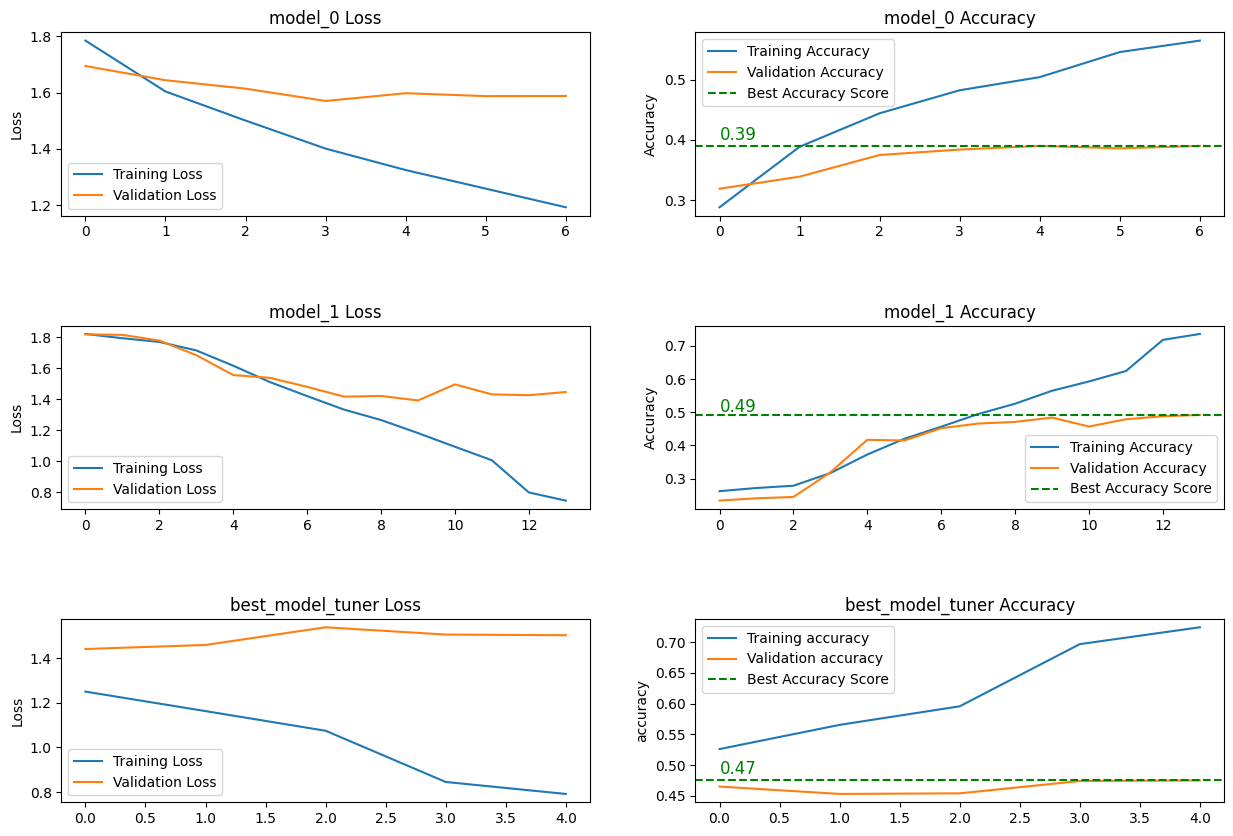

In [94]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.title('model_0 Loss')
plt.ylabel('Loss')
plt.plot(history_0.history['loss'], label='Training Loss')
plt.plot(history_0.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')

plt.subplot(3, 2, 2)
plt.title('model_0 Accuracy')
plt.ylabel('Accuracy')
plt.plot(history_0.history['accuracy'], label='Training Accuracy')
plt.plot(history_0.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=model_0_acc, color='g', linestyle='--', label='Best Accuracy Score')
plt.legend(loc='upper left')
plt.text(0, model_0_acc + 0.01, f'{model_0_acc:.2f}', color='g', size=12)

plt.subplot(3, 2, 3)
plt.title('model_1 Loss')
plt.ylabel('Loss')
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')


plt.subplot(3, 2, 4)
plt.title('model_1 Accuracy')
plt.ylabel('Accuracy')
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=model_1_acc, color='g', linestyle='--', label='Best Accuracy Score')
plt.legend(loc='lower right')
plt.text(0, model_1_acc + 0.01, f'{model_1_acc:.2f}', color='g', size=12)

plt.subplot(3, 2, 5)
plt.title('best_model_tuner Loss')
plt.ylabel('Loss')
plt.plot(best_tuned_model_history.history['loss'], label='Training Loss')
plt.plot(best_tuned_model_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower left')

plt.subplot(3, 2, 6)
plt.title('best_model_tuner Accuracy')
plt.ylabel('accuracy')
plt.plot(best_tuned_model_history.history['accuracy'], label='Training accuracy')
plt.plot(best_tuned_model_history.history['val_accuracy'], label='Validation accuracy')
plt.axhline(y=best_tuned_model_acc, color='g', linestyle='--', label='Best Accuracy Score')
plt.legend(loc='upper left')
plt.text(0, best_tuned_model_acc + 0.01, f'{best_tuned_model_acc:.2f}', color='g', size=12)

plt.subplots_adjust(hspace=0.6)

It seems model_1 performed the best on the reduced dataset.
Let's train that one on the whole data

In [54]:
# Create full training dataset

X_train_full = np.concatenate((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))


In [60]:
final_model = load_model('./model_1.h5')

In [61]:
final_model_checkpoint = ModelCheckpoint('./final_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [62]:
final_model_history = final_model.fit(X_train_full, y_train_full, batch_size=100, epochs=50, callbacks=[early_stop, reduce_lr_loss, final_model_checkpoint], validation_split=0.2)

Epoch 1/50
231/231 [==============================] - ETA: 0s - loss: 1.3292 - accuracy: 0.5260
Epoch 1: val_accuracy improved from -inf to 0.49939, saving model to .\final_model.h5
231/231 [==============================] - 184s 796ms/step - loss: 1.3292 - accuracy: 0.5260 - val_loss: 1.3096 - val_accuracy: 0.4994 - lr: 1.0000e-04
Epoch 2/50


c:\Users\olofs\anaconda3\envs\deep_learning\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/231 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.5358
Epoch 2: val_accuracy improved from 0.49939 to 0.50616, saving model to .\final_model.h5
231/231 [==============================] - 182s 788ms/step - loss: 1.2645 - accuracy: 0.5358 - val_loss: 1.2886 - val_accuracy: 0.5062 - lr: 1.0000e-04
Epoch 3/50
231/231 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.5412
Epoch 3: val_accuracy improved from 0.50616 to 0.51362, saving model to .\final_model.h5
231/231 [==============================] - 171s 740ms/step - loss: 1.2446 - accuracy: 0.5412 - val_loss: 1.2727 - val_accuracy: 0.5136 - lr: 1.0000e-04
Epoch 4/50
231/231 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.5480
Epoch 4: val_accuracy improved from 0.51362 to 0.52160, saving model to .\final_model.h5
231/231 [==============================] - 169s 730ms/step - loss: 1.2249 - accuracy: 0.5480 - val_loss: 1.2634 - val_accuracy: 0.5216 - lr: 1.0000e-04


In [63]:
final_model_loaded = load_model('./final_model.h5')
eva_final_model = final_model_loaded.evaluate(X_test, y_test)
final_model_acc = eva_final_model[1]

221/221 [==============================] - 8s 37ms/step - loss: 1.1560 - accuracy: 0.5817


Text(0, 0.586658661365509, '0.58')

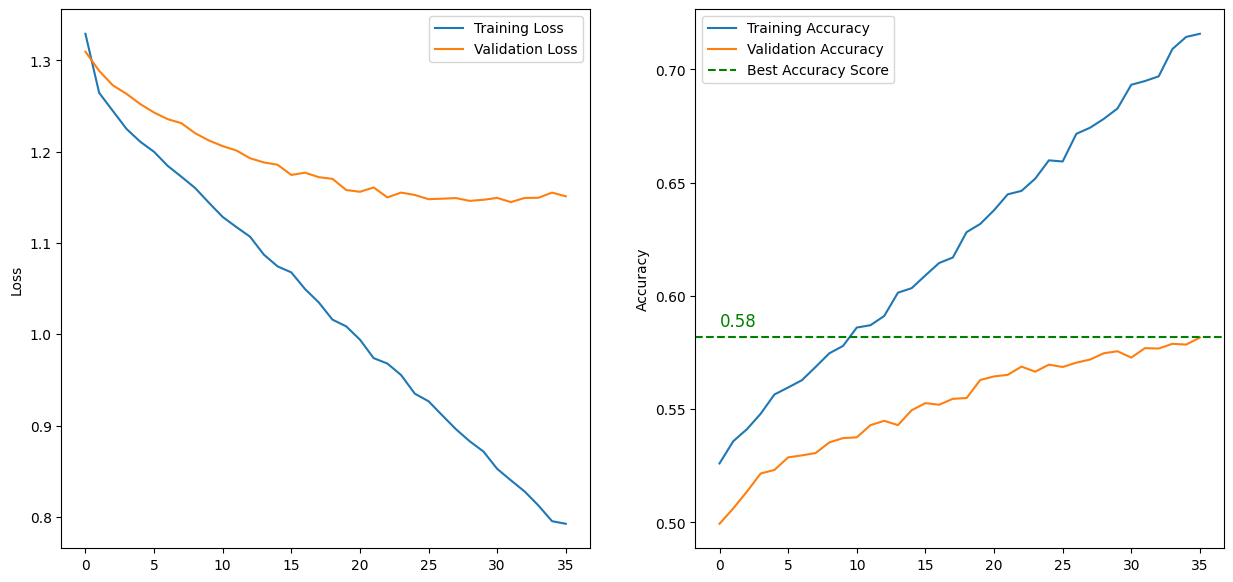

In [95]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.plot(final_model_history.history['loss'], label='Training Loss')
plt.plot(final_model_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy')
plt.plot(final_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(final_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=final_model_acc, color='g', linestyle='--', label='Best Accuracy Score')
plt.legend(loc='upper left')
plt.text(0, final_model_acc + 0.005, f'{final_model_acc:.2f}', color='g', size=12)

In [99]:
y_pred = final_model.predict(X_test)


221/221 [==============================] - 9s 40ms/step


In [70]:
y_pred_cat = to_categorical(np.argmax(y_pred, axis=1))

In [98]:
acc = accuracy_score(y_test, y_pred_cat)
acc

0.5816586470421737

In [74]:
y_test_numeric = np.argmax(y_test, axis=1)
y_pred_numeric = np.argmax(y_pred_cat, axis=1)

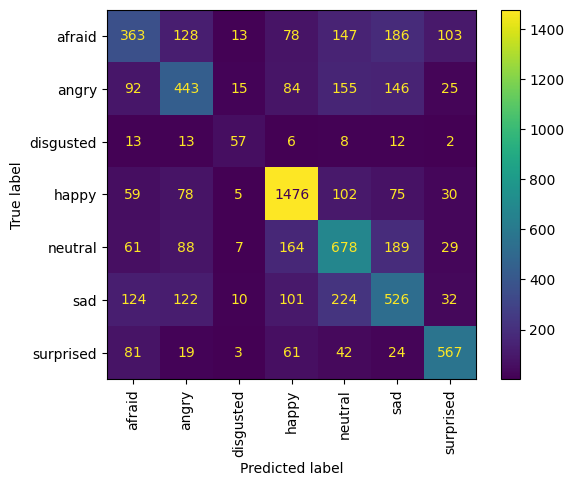

In [80]:
ConfusionMatrixDisplay(confusion_matrix(y_test_numeric, y_pred_numeric), display_labels=expressions_list).plot(xticks_rotation='vertical')

In [85]:
print(classification_report(y_test, y_pred_cat))


              precision    recall  f1-score   support

           0       0.46      0.36      0.40      1018
           1       0.50      0.46      0.48       960
           2       0.52      0.51      0.52       111
           3       0.75      0.81      0.78      1825
           4       0.50      0.56      0.53      1216
           5       0.45      0.46      0.46      1139
           6       0.72      0.71      0.72       797

   micro avg       0.58      0.58      0.58      7066
   macro avg       0.56      0.55      0.55      7066
weighted avg       0.58      0.58      0.58      7066
 samples avg       0.58      0.58      0.58      7066

